<a href="https://colab.research.google.com/github/limweiliang/weed-classifier/blob/main/CS3244_ProjectCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Nov  8 08:36:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8     8W /  N/A |   1162MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 9

# ds = tfds.load('deep_weeds', batch_size = -1, as_supervised= True)
# images, labels = ds['train'] # Type: EagerTensor

# # Shuffle the dataset
# images = tf.random.shuffle(images, seed=RANDOM_STATE)
# labels = tf.random.shuffle(labels, seed=RANDOM_STATE)

# print(images.shape, labels.shape)

# # Split dataset into train-val-test
# num_images = images.shape[0]
# last_train_image = math.floor(num_images * 0.6)
# last_val_image = math.floor(num_images * 0.8)

# X_train = images[:last_train_image]
# y_train = labels[:last_train_image]
# X_val = images[last_train_image:last_val_image]
# y_val = labels[last_train_image:last_val_image]
# X_test = images[last_val_image:]
# y_test = labels[last_val_image:]

# print(X_train.shape, X_val.shape, X_test.shape)

In [5]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"], batch_size = BATCH_SIZE)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

def one_hot(img, label):
    return (img, tf.one_hot(label,9))

def add_grey_grad(img ,label):
    org_img = img
    img = tf.cast(img, float)
    #img = tf.expand_dims(img, axis = 0)
    gray = tf.image.rgb_to_grayscale(img)
    dy , dx = tf.image.image_gradients(gray)
    dmag = tf.math.sqrt(tf.add(tf.math.square(dy),tf.math.square(dx)))
    mean = tf.math.reduce_sum(dmag)/(256*256)
    out = (dmag / mean) * 255
    out = tf.expand_dims(tf.cast(out, tf.uint8), axis = 0)
    gray = tf.expand_dims(tf.cast(gray, tf.uint8), axis = 0)
    org_img = tf.concat([org_img,gray[0],out[0]],-1)
    return (org_img, label)

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

train_ds = train_ds.map(add_grey_grad)
validation_ds = validation_ds.map(add_grey_grad)
test_ds = test_ds.map(add_grey_grad)


train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

Number of training samples: 766
Number of validation samples: 219
Number of test samples: 110


In [6]:
# Clean up memory usage
# del ds
# del images
# del labels

In [7]:
from tensorflow.keras import datasets, layers, models, regularizers, Input
import datetime

In [18]:
inputs = Input(shape = (256,256,5), name = "Original_Image")
flip = layers.RandomFlip("horizontal_and_vertical")(inputs)
rotate = layers.RandomRotation((-0.5,0.5), fill_mode = "nearest")(flip)
rescale = layers.Rescaling(1/255)(rotate)

x = layers.Conv2D(64, (3,3), padding = "same", strides = 2)(rescale)
x = layers.Conv2D(128, (5,5), padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
block_1_output = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), padding = "same", strides = 2)(block_1_output)
x = layers.Conv2D(128, (3,3), padding = "same", strides = 2)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
block_2_output = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (3,3), padding = "same", strides = 2)(block_2_output)
x = layers.Conv2D(64, (3,3), padding = "same", strides = 2)(x)
x = layers.BatchNormalization()(x)
block_3_output = layers.ReLU()(x)

x = layers.Flatten()(block_3_output)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs, name="3_block_CNN")
model.summary()

Model: "3_block_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Original_Image (InputLayer)  [(None, 256, 256, 5)]     0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 256, 256, 5)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 256, 256, 5)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 256, 256, 5)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 64)      2944      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 128)     204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 128)     

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.01)


model.compile(optimizer=optimizer,
              loss= 'categorical_crossentropy',
              metrics=['accuracy', "Precision", "Recall"])

In [20]:
model.summary()

Model: "3_block_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Original_Image (InputLayer)  [(None, 256, 256, 5)]     0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 256, 256, 5)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 256, 256, 5)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 256, 256, 5)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 64)      2944      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 128)     204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 128)     

In [21]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True , verbose = 1)

#Constant learning rate for first N epochs then it decreases exponentially
# def scheduler(epoch, lr):
#   if epoch < 65:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1/5)

# lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, cooldown=10, verbose = 1)

In [22]:
hist = model.fit(train_ds, epochs=200,
                     validation_data= validation_ds, callbacks=[EarlyStop, reduce_lr],batch_size = BATCH_SIZE)

Epoch 1/200
766/766 [==============================] - 74s 95ms/step - loss: 1.6131 - accuracy: 0.5142 - precision: 0.6521 - recall: 0.3253 - val_loss: 1.7891 - val_accuracy: 0.5157 - val_precision: 0.5697 - val_recall: 0.4843
Epoch 2/200
766/766 [==============================] - 75s 99ms/step - loss: 1.3663 - accuracy: 0.5395 - precision: 0.7122 - recall: 0.3798 - val_loss: 1.6785 - val_accuracy: 0.4814 - val_precision: 0.5754 - val_recall: 0.1242
Epoch 3/200
766/766 [==============================] - 76s 99ms/step - loss: 1.3101 - accuracy: 0.5447 - precision: 0.7295 - recall: 0.3924 - val_loss: 1.6569 - val_accuracy: 0.4535 - val_precision: 0.4521 - val_recall: 0.1833
Epoch 4/200
766/766 [==============================] - 75s 98ms/step - loss: 1.2745 - accuracy: 0.5494 - precision: 0.7427 - recall: 0.3948 - val_loss: 1.5385 - val_accuracy: 0.4623 - val_precision: 0.5099 - val_recall: 0.2050
Epoch 5/200
766/766 [==============================] - 76s 99ms/step - loss: 1.2455 - accura

766/766 [==============================] - 74s 97ms/step - loss: 0.6396 - accuracy: 0.7703 - precision: 0.8280 - recall: 0.7110 - val_loss: 0.7299 - val_accuracy: 0.7441 - val_precision: 0.8066 - val_recall: 0.6907
Epoch 37/200
766/766 [==============================] - 74s 96ms/step - loss: 0.6303 - accuracy: 0.7795 - precision: 0.8364 - recall: 0.7195 - val_loss: 0.7413 - val_accuracy: 0.7473 - val_precision: 0.8052 - val_recall: 0.6859
Epoch 38/200
766/766 [==============================] - 73s 96ms/step - loss: 0.6286 - accuracy: 0.7777 - precision: 0.8381 - recall: 0.7216 - val_loss: 0.7016 - val_accuracy: 0.7599 - val_precision: 0.8129 - val_recall: 0.7085
Epoch 39/200
766/766 [==============================] - 75s 98ms/step - loss: 0.6197 - accuracy: 0.7792 - precision: 0.8377 - recall: 0.7230 - val_loss: 0.7598 - val_accuracy: 0.7393 - val_precision: 0.7968 - val_recall: 0.6853
Epoch 40/200
766/766 [==============================] - 74s 96ms/step - loss: 0.6165 - accuracy: 0.77

766/766 [==============================] - 72s 94ms/step - loss: 0.4109 - accuracy: 0.8553 - precision: 0.8868 - recall: 0.8281 - val_loss: 0.5695 - val_accuracy: 0.8104 - val_precision: 0.8513 - val_recall: 0.7850
Epoch 72/200
766/766 [==============================] - 74s 97ms/step - loss: 0.4066 - accuracy: 0.8562 - precision: 0.8897 - recall: 0.8285 - val_loss: 0.5425 - val_accuracy: 0.8235 - val_precision: 0.8599 - val_recall: 0.7958
Epoch 73/200
766/766 [==============================] - 72s 94ms/step - loss: 0.4073 - accuracy: 0.8576 - precision: 0.8905 - recall: 0.8300 - val_loss: 0.5664 - val_accuracy: 0.8130 - val_precision: 0.8522 - val_recall: 0.7836
Epoch 74/200
766/766 [==============================] - 72s 94ms/step - loss: 0.4092 - accuracy: 0.8538 - precision: 0.8860 - recall: 0.8247 - val_loss: 0.5433 - val_accuracy: 0.8230 - val_precision: 0.8583 - val_recall: 0.7853
Epoch 75/200
766/766 [==============================] - 74s 97ms/step - loss: 0.4084 - accuracy: 0.85

766/766 [==============================] - 78s 102ms/step - loss: 0.3533 - accuracy: 0.8743 - precision: 0.9034 - recall: 0.8525 - val_loss: 0.5129 - val_accuracy: 0.8392 - val_precision: 0.8729 - val_recall: 0.8115

Epoch 00105: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 106/200
766/766 [==============================] - 78s 102ms/step - loss: 0.3469 - accuracy: 0.8771 - precision: 0.9040 - recall: 0.8534 - val_loss: 0.5106 - val_accuracy: 0.8389 - val_precision: 0.8736 - val_recall: 0.8130
Epoch 107/200
766/766 [==============================] - 77s 100ms/step - loss: 0.3482 - accuracy: 0.8766 - precision: 0.9039 - recall: 0.8537 - val_loss: 0.5130 - val_accuracy: 0.8389 - val_precision: 0.8698 - val_recall: 0.8130
Epoch 108/200
766/766 [==============================] - 80s 104ms/step - loss: 0.3495 - accuracy: 0.8788 - precision: 0.9045 - recall: 0.8556 - val_loss: 0.5130 - val_accuracy: 0.8392 - val_precision: 0.8740 - val_recall: 0.8121
Epoch 109/20

766/766 [==============================] - 77s 100ms/step - loss: 0.3422 - accuracy: 0.8826 - precision: 0.9103 - recall: 0.8611 - val_loss: 0.5100 - val_accuracy: 0.8421 - val_precision: 0.8731 - val_recall: 0.8175
Epoch 140/200
766/766 [==============================] - 77s 101ms/step - loss: 0.3353 - accuracy: 0.8808 - precision: 0.9083 - recall: 0.8579 - val_loss: 0.5127 - val_accuracy: 0.8415 - val_precision: 0.8716 - val_recall: 0.8181
Epoch 141/200
766/766 [==============================] - 77s 101ms/step - loss: 0.3405 - accuracy: 0.8785 - precision: 0.9037 - recall: 0.8576 - val_loss: 0.5127 - val_accuracy: 0.8415 - val_precision: 0.8730 - val_recall: 0.8184
Epoch 142/200
766/766 [==============================] - 77s 101ms/step - loss: 0.3414 - accuracy: 0.8818 - precision: 0.9076 - recall: 0.8583 - val_loss: 0.5122 - val_accuracy: 0.8401 - val_precision: 0.8723 - val_recall: 0.8190
Epoch 143/200
766/766 [==============================] - 76s 100ms/step - loss: 0.3440 - accur

766/766 [==============================] - 76s 100ms/step - loss: 0.3345 - accuracy: 0.8826 - precision: 0.9092 - recall: 0.8612 - val_loss: 0.5103 - val_accuracy: 0.8407 - val_precision: 0.8727 - val_recall: 0.8184
Epoch 175/200
766/766 [==============================] - 77s 100ms/step - loss: 0.3396 - accuracy: 0.8834 - precision: 0.9069 - recall: 0.8602 - val_loss: 0.5094 - val_accuracy: 0.8415 - val_precision: 0.8715 - val_recall: 0.8190
Epoch 176/200
766/766 [==============================] - 76s 99ms/step - loss: 0.3396 - accuracy: 0.8802 - precision: 0.9084 - recall: 0.8597 - val_loss: 0.5084 - val_accuracy: 0.8418 - val_precision: 0.8724 - val_recall: 0.8181
Epoch 177/200
766/766 [==============================] - 75s 97ms/step - loss: 0.3384 - accuracy: 0.8828 - precision: 0.9087 - recall: 0.8592 - val_loss: 0.5087 - val_accuracy: 0.8421 - val_precision: 0.8728 - val_recall: 0.8187
Epoch 178/200
766/766 [==============================] - 75s 97ms/step - loss: 0.3371 - accuracy

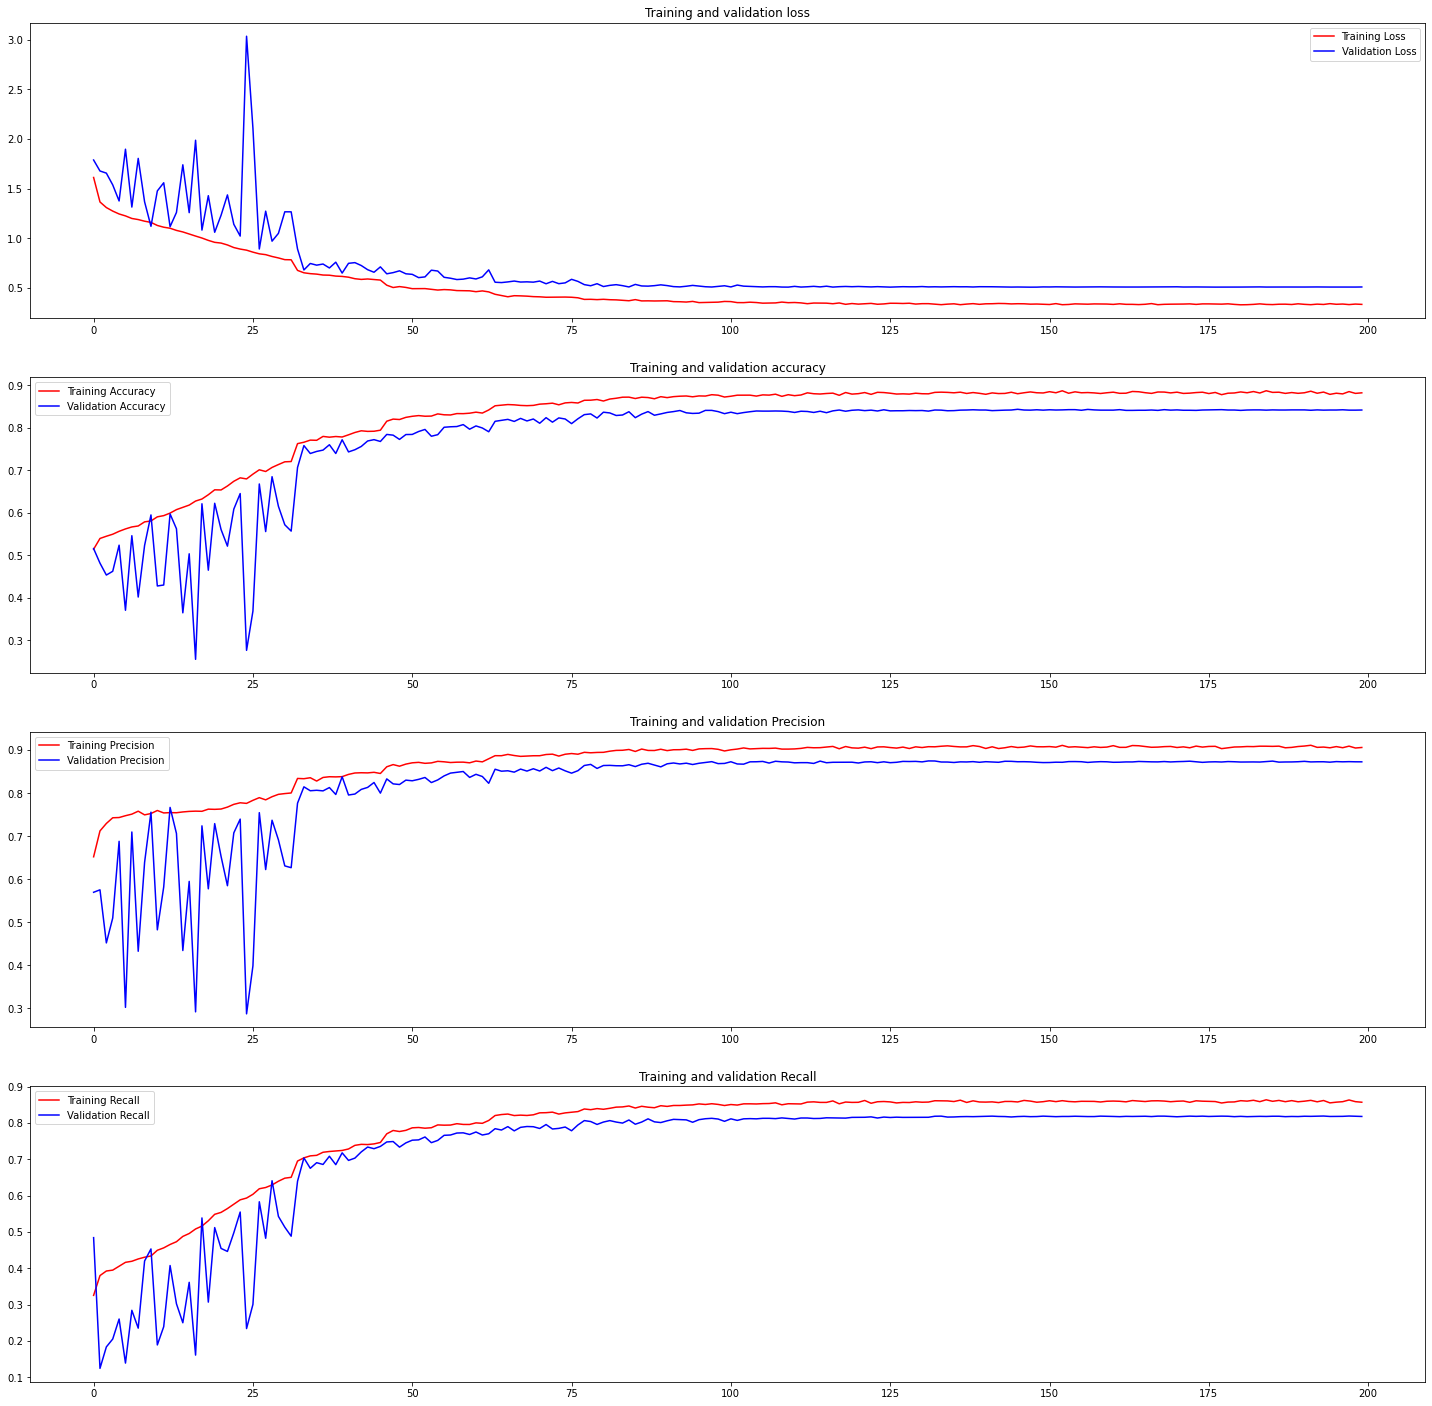

In [23]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
precision = hist.history['precision']
val_precision = hist.history['val_precision']
recall = hist.history['recall']
val_recall = hist.history['val_recall']

# Plot the graph manually
epochs = range(len(loss))

plt.figure(figsize=(25, 25))
plt.subplot(4, 1, 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and validation Precision')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(epochs, recall, 'r', label = "Training Recall")
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.show()

In [24]:
model.evaluate(validation_ds)

219/219 [==============================] - 8s 36ms/step - loss: 0.5101 - accuracy: 0.8415 - precision: 0.8727 - recall: 0.8181


[0.5100734233856201,
 0.8415191173553467,
 0.8726774454116821,
 0.8181039690971375]

In [25]:
model.save('./CNN_Models/3_block_cnn/3_blockV2.h5')

In [26]:
test = tfds.as_numpy(test_ds)
y_pred = []
y_label = []

for i in test:
  flat_img = i[0]
  flat_label = i[1]
  pred = model.predict(flat_img)
  pred = np.argmax(pred, axis=1)
  y_pred.extend(pred)
  y_label.extend(np.argmax(flat_label, axis = 1))

y_pred = np.array(y_pred)
y_label = np.array(y_label)

In [27]:
len(y_pred)

1751

In [28]:
from sklearn.metrics import classification_report

print(y_pred)
print(classification_report(y_label, y_pred))

[6 8 0 ... 2 8 8]
              precision    recall  f1-score   support

           0       0.63      0.62      0.63       103
           1       0.80      0.78      0.79        90
           2       0.81      0.87      0.84       116
           3       0.76      0.86      0.81       105
           4       0.74      0.78      0.76       108
           5       0.88      0.87      0.87        98
           6       0.84      0.90      0.87       114
           7       0.79      0.60      0.68       129
           8       0.90      0.90      0.90       888

    accuracy                           0.84      1751
   macro avg       0.80      0.80      0.79      1751
weighted avg       0.84      0.84      0.84      1751

